In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import caffe
import time
import glob

In [2]:
def top_k(result, top_num, label_arr):
    tmp = -(top_num+1)
    top_k = result.flatten().argsort()[-1:tmp:-1]
    top_num = 1
    for i in np.arange(top_k.size):
        print("Top %d:\tProb:%2.4f%%\t[%d]\t %s"%(top_num,result[top_k[i]]*100,top_k[i], labels[top_k[i]]))
        top_num = top_num + 1

In [3]:
def read_files(path,fileType):
    dimg_files = []
    for root, directories, filenames in os.walk(path):
        for filename in filenames:
            if fileType in filename:
                dimg_files.append(os.path.join(root,filename))
    return dimg_files

In [4]:
def read_dimg(dimg_file):
    return np.genfromtxt(dimg_file, float, delimiter=' ')

In [5]:
def get_image_path(basename,path,ext):
    return(path + os.path.basename(basename).split('.')[0] + ext)

In [6]:
def loss_rate(arr1, arr2):
#     print arr1, arr2
    return np.sum(np.absolute(np.subtract(arr1,arr2)))/len(arr1)

In [7]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce

In [8]:
def caffe_inference(image_path):
    
    # Configure
    pycaffe_dir = '/home/caslab/workspace/caffe/caffe/python/'
    model_dir = '/home/caslab/workspace/NVDLA/sw_5_17/sw/prebuilt/linux/model/'
    input_file = image_path
    model_def = os.path.join(model_dir,"cifar10/cifar10_quick.prototxt")
    pretrained_model = os.path.join(model_dir,"cifar10/cifar10_quick_iter_4000.caffemodel")
    gpu = False
    center_only = True
    images_dim = '32,32'
    mean_file = '/home/caslab/workspace/caffe/caffe/examples/cifar10/mean.npy'
    # input_scale = 
    raw_scale = 255.0
    channel_swap = '2,1,0'
    ext = 'jpg'
    image_dims = [int(s) for s in images_dim.split(',')]
    mean, channel_swap_arr = None, None
    
    
    
    # Setup parameter
    if mean_file:
        mean = np.load(mean_file)
    if channel_swap:
        channel_swap_arr = [int(s) for s in channel_swap.split(',')]
    if gpu:
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()

    
    # Create classifier class
    classifier = caffe.Classifier(model_def, pretrained_model,
            image_dims=image_dims, mean=None,
    #         image_dims=image_dims, mean=mean,
            raw_scale=raw_scale,
            channel_swap=channel_swap_arr)


    
    # Load image file.
    inputs =[caffe.io.load_image(input_file)]
    load_img_time_end = time.time()

    # Classify
    predictions = classifier.predict(inputs, not center_only)
    
    return predictions[0]

In [9]:
labels_filename = '/home/caslab/workspace/dataset/cifar/labels.txt'
labels = np.loadtxt(labels_filename, str, delimiter='\t')
print("Read label ... %s"%labels_filename)
print ("Number of class is %d"%len(labels))

Read label ... /home/caslab/workspace/dataset/cifar/labels.txt
Number of class is 10


In [10]:
dimg_root_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/runtime/test/dimg_cifar10_quick_full/'
dimg_files = read_files(dimg_root_path,'dimg')
image_root_path = '/home/caslab/workspace/dataset/cifar/mix/'
test_name = []
caffe_nvdla_loss = []
nvdla_result = []
caffe_result = []
caffe_nvdla_cross_entropy = []

for element in dimg_files:
    test_name.append(os.path.basename(element).split('.')[0])
    nvdla_result.append(read_dimg(element))
    caffe_result.append(caffe_inference(get_image_path(element,image_root_path,'.jpg')))
    caffe_nvdla_loss.append(loss_rate(read_dimg(element),caffe_inference(get_image_path(element,image_root_path,'.jpg'))))
    caffe_nvdla_cross_entropy.append(cross_entropy(read_dimg(element),caffe_inference(get_image_path(element,image_root_path,'.jpg'))))
# print caffe_nvdla_loss
print("Total loss rate mean(%d): %f%%"%(len(caffe_nvdla_loss),np.sum(caffe_nvdla_loss)*100/len(caffe_nvdla_loss)))

Total loss rate mean(42): 3.459663%


In [30]:
for z in range(0,42):
    print("\n%s" % test_name[z])
    print("Caffe Prediction Result No Mean")
    top_k(result = caffe_result[z], top_num = 10, label_arr = labels)
    
    print("NVDLA Prediction Result No Mean")
    top_k(result = nvdla_result[z], top_num = 10, label_arr = labels)
    print("-----------loss rate: %2.3f%% | cross entropy: %f -----------------"%((caffe_nvdla_loss[z]*100),(caffe_nvdla_cross_entropy[z])))



103_frog
Caffe Prediction Result No Mean
Top 1:	Prob:92.9802%	[5]	 dog
Top 2:	Prob:6.2379%	[3]	 cat
Top 3:	Prob:0.3295%	[4]	 deer
Top 4:	Prob:0.3073%	[7]	 horse
Top 5:	Prob:0.0772%	[2]	 bird
Top 6:	Prob:0.0239%	[0]	 airplane
Top 7:	Prob:0.0234%	[6]	 frog
Top 8:	Prob:0.0098%	[8]	 ship
Top 9:	Prob:0.0061%	[1]	 automobile
Top 10:	Prob:0.0048%	[9]	 truck
NVDLA Prediction Result No Mean
Top 1:	Prob:87.5977%	[5]	 dog
Top 2:	Prob:5.9326%	[3]	 cat
Top 3:	Prob:3.1860%	[4]	 deer
Top 4:	Prob:1.8982%	[7]	 horse
Top 5:	Prob:0.9209%	[2]	 bird
Top 6:	Prob:0.2016%	[0]	 airplane
Top 7:	Prob:0.1416%	[8]	 ship
Top 8:	Prob:0.0606%	[6]	 frog
Top 9:	Prob:0.0348%	[9]	 truck
Top 10:	Prob:0.0217%	[1]	 automobile
-----------loss rate: 1.137% | cross entropy: 0.033123 -----------------

21_cat
Caffe Prediction Result No Mean
Top 1:	Prob:63.8302%	[3]	 cat
Top 2:	Prob:28.0109%	[5]	 dog
Top 3:	Prob:7.0783%	[0]	 airplane
Top 4:	Prob:0.8610%	[2]	 bird
Top 5:	Prob:0.1180%	[4]	 deer
Top 6:	Prob:0.0781%	[7]	 horse
Top 

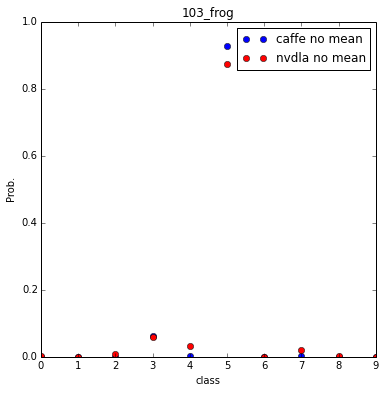

-----------loss rate: 1.137% | cross entropy: 0.033123 -----------------


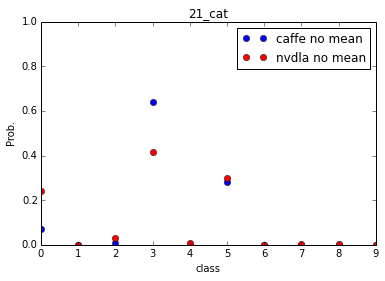

-----------loss rate: 4.411% | cross entropy: 0.103895 -----------------


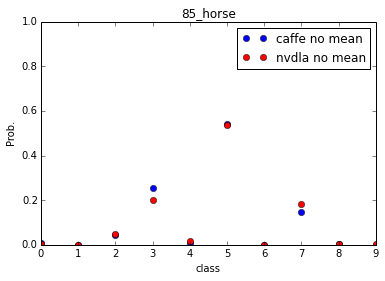

-----------loss rate: 1.138% | cross entropy: 0.120716 -----------------


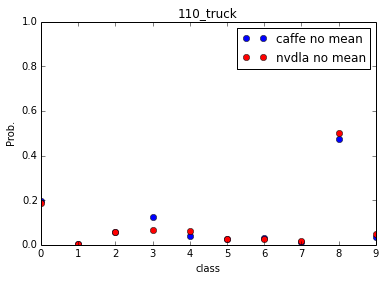

-----------loss rate: 1.461% | cross entropy: 0.164656 -----------------


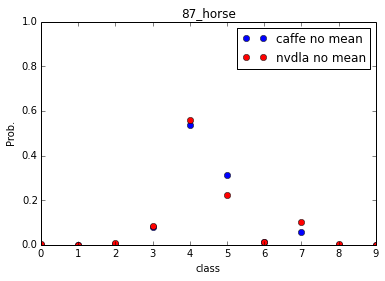

-----------loss rate: 1.783% | cross entropy: 0.117028 -----------------


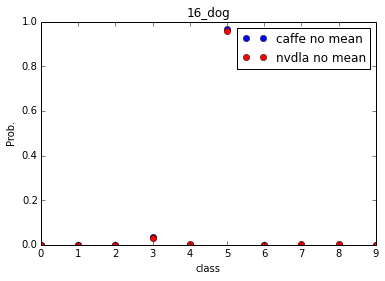

-----------loss rate: 0.147% | cross entropy: 0.016461 -----------------


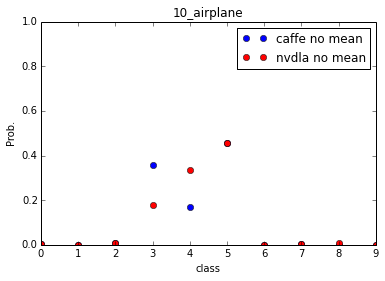

-----------loss rate: 3.649% | cross entropy: 0.123493 -----------------


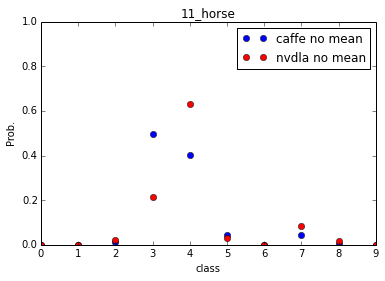

-----------loss rate: 5.903% | cross entropy: 0.127137 -----------------


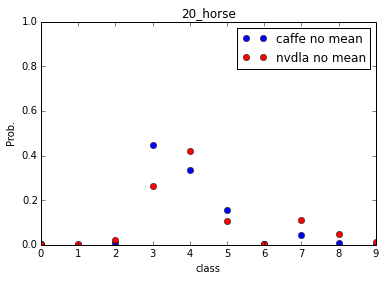

-----------loss rate: 4.600% | cross entropy: 0.140847 -----------------


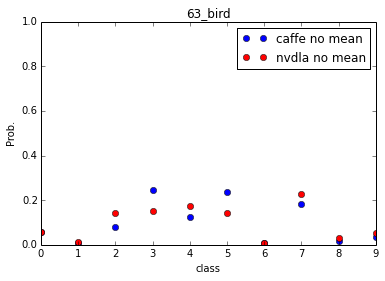

-----------loss rate: 3.764% | cross entropy: 0.197364 -----------------


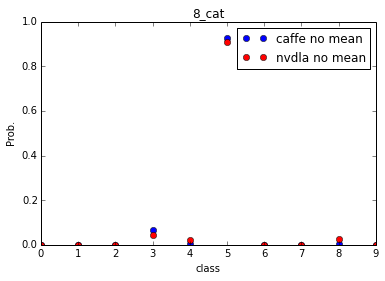

-----------loss rate: 0.808% | cross entropy: 0.033556 -----------------


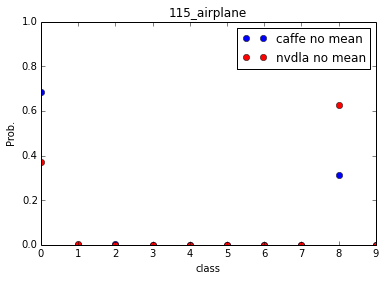

-----------loss rate: 6.344% | cross entropy: 0.084957 -----------------


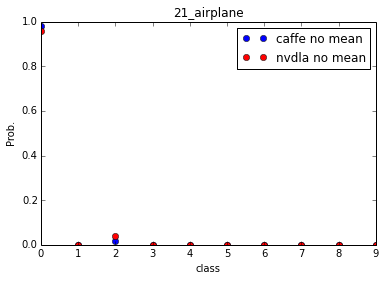

-----------loss rate: 0.449% | cross entropy: 0.010356 -----------------


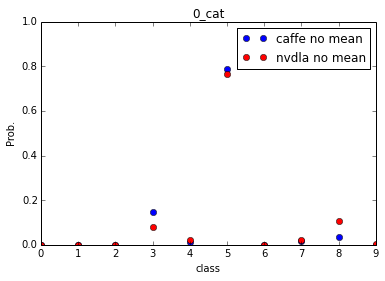

-----------loss rate: 1.680% | cross entropy: 0.078981 -----------------


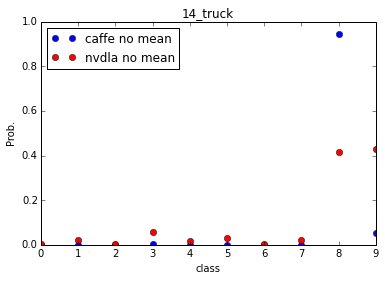

-----------loss rate: 10.536% | cross entropy: 0.088649 -----------------


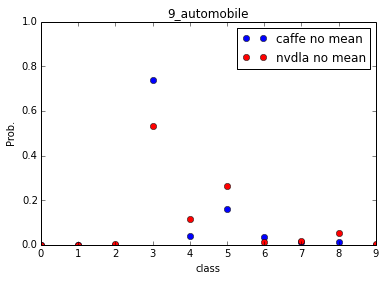

-----------loss rate: 4.515% | cross entropy: 0.101302 -----------------


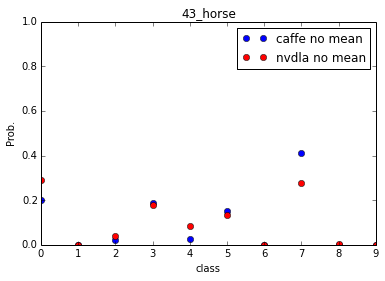

-----------loss rate: 3.260% | cross entropy: 0.155282 -----------------


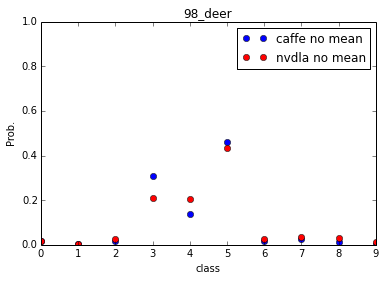

-----------loss rate: 2.464% | cross entropy: 0.143923 -----------------


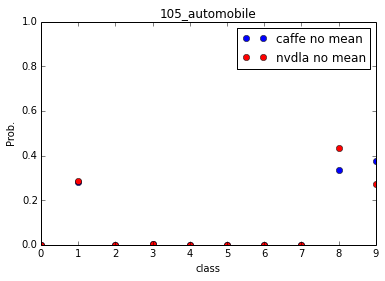

-----------loss rate: 2.072% | cross entropy: 0.115251 -----------------


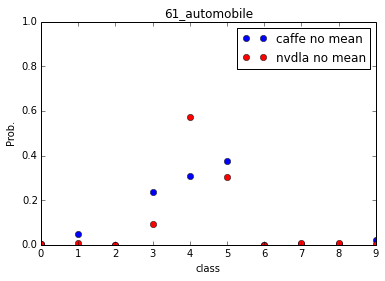

-----------loss rate: 5.437% | cross entropy: 0.158200 -----------------


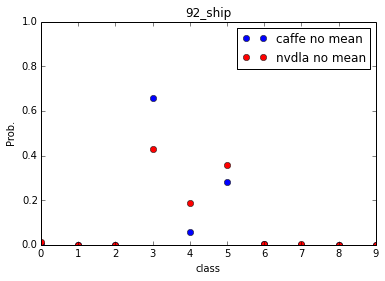

-----------loss rate: 4.494% | cross entropy: 0.096159 -----------------


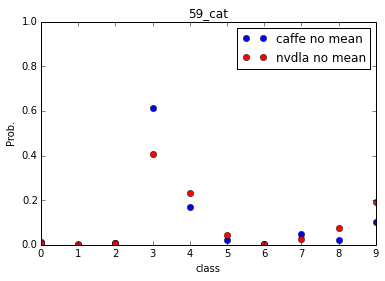

-----------loss rate: 4.668% | cross entropy: 0.138312 -----------------


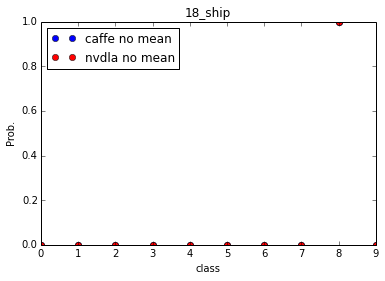

-----------loss rate: 0.002% | cross entropy: 0.000420 -----------------


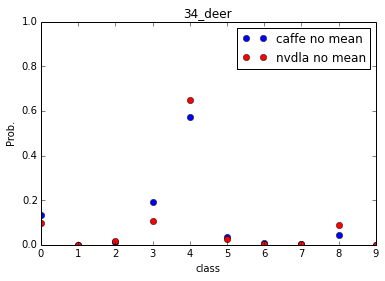

-----------loss rate: 2.645% | cross entropy: 0.132918 -----------------


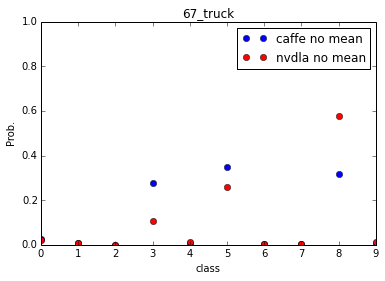

-----------loss rate: 5.404% | cross entropy: 0.152484 -----------------


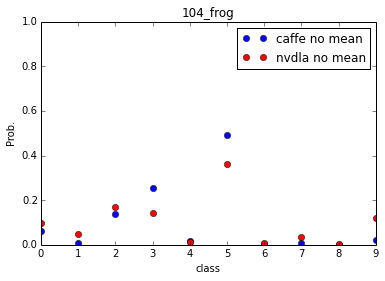

-----------loss rate: 4.835% | cross entropy: 0.155926 -----------------


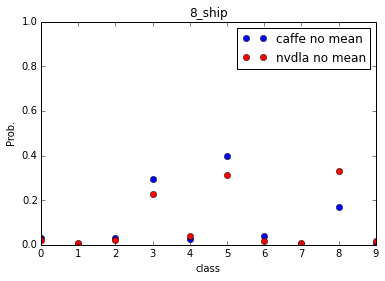

-----------loss rate: 3.845% | cross entropy: 0.162707 -----------------


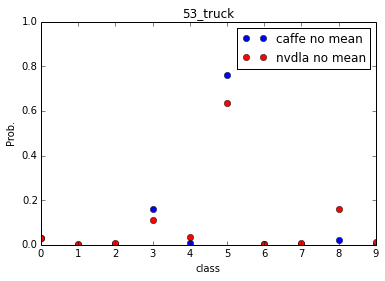

-----------loss rate: 3.512% | cross entropy: 0.095597 -----------------


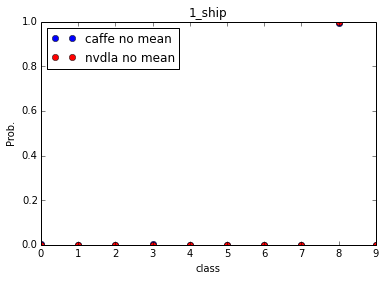

-----------loss rate: 0.059% | cross entropy: 0.003974 -----------------


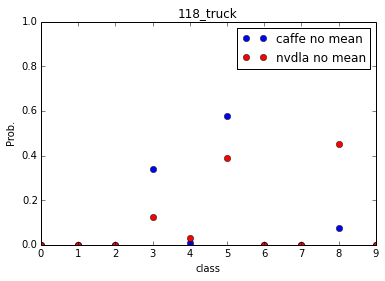

-----------loss rate: 8.027% | cross entropy: 0.134111 -----------------


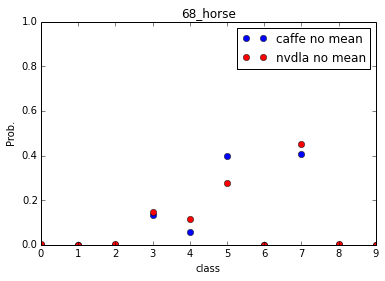

-----------loss rate: 2.415% | cross entropy: 0.122769 -----------------


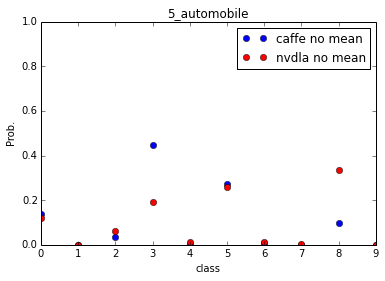

-----------loss rate: 5.636% | cross entropy: 0.164833 -----------------


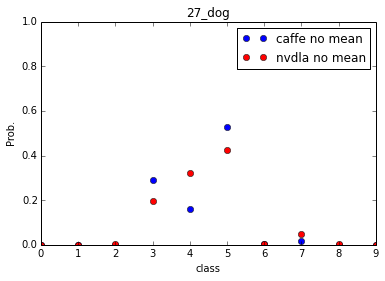

-----------loss rate: 4.027% | cross entropy: 0.117999 -----------------


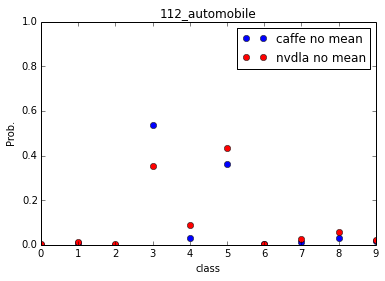

-----------loss rate: 3.711% | cross entropy: 0.119643 -----------------


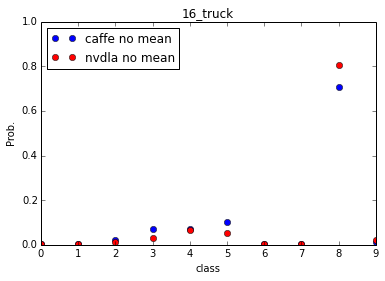

-----------loss rate: 2.186% | cross entropy: 0.111714 -----------------


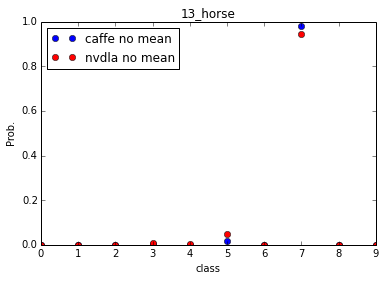

-----------loss rate: 0.768% | cross entropy: 0.011638 -----------------


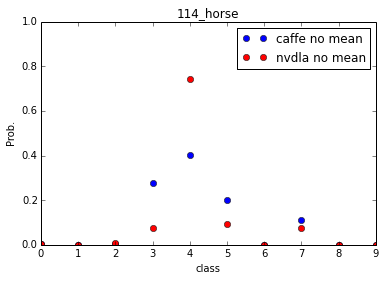

-----------loss rate: 6.937% | cross entropy: 0.164939 -----------------


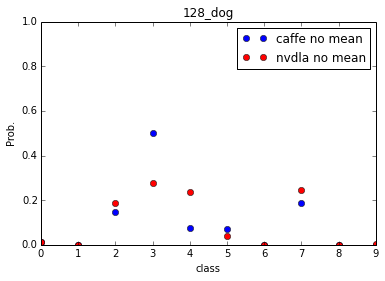

-----------loss rate: 5.119% | cross entropy: 0.156391 -----------------


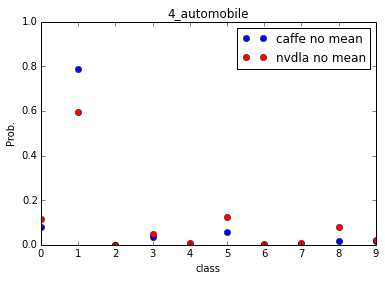

-----------loss rate: 3.895% | cross entropy: 0.094000 -----------------


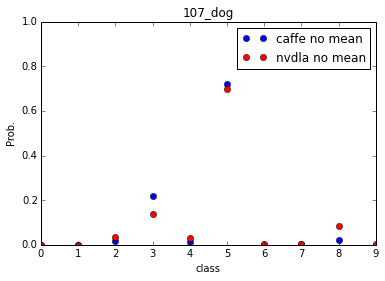

-----------loss rate: 1.991% | cross entropy: 0.089154 -----------------


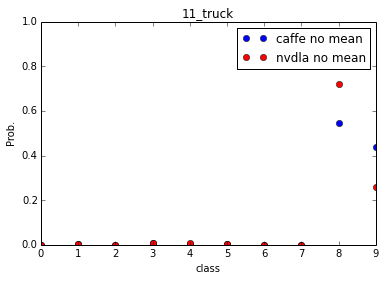

-----------loss rate: 3.633% | cross entropy: 0.085565 -----------------


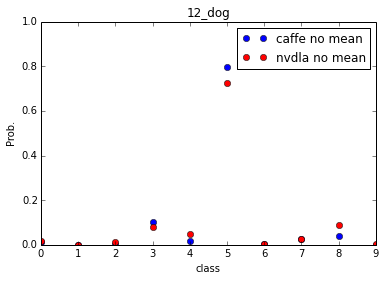

-----------loss rate: 1.938% | cross entropy: 0.084630 -----------------


In [29]:
pixel_width = 6
pixel_height = 6
plt.figure(figsize=(pixel_width, pixel_height))
aa = range(0,10)
for z in range(0,42):
    l1, = plt.plot(aa,caffe_result[z], 'bo' , label = 'caffe no mean')
    l2, = plt.plot(aa,nvdla_result[z], 'ro' , label = 'nvdla no mean')


    plt.xlim((0, 9))
    plt.ylim((0, 1))
    plt.title(test_name[z])
    plt.xlabel('class')
    plt.ylabel('Prob.')
    
#     plt.legend(handles = [l1, l2,], labels = ['caffe', 'nvdla'], loc = 'best')
    plt.legend(loc = 'best') #, labels = ['caffe', 'no mean'], loc = 'best')

    plt.show()
    print("-----------loss rate: %2.3f%% | cross entropy: %f -----------------"%((caffe_nvdla_loss[z]*100),(caffe_nvdla_cross_entropy[z])))
# 
# # print aa
# plt.plot(aa,predictions[0],'y--',aa, dimg_no_mean , 'r--', aa, dimg_mean_bgr, 'b--', aa, dimg_mean_rgb, 'g--')
# plt.axis([0, 50, 0, 1])
# plt.show()

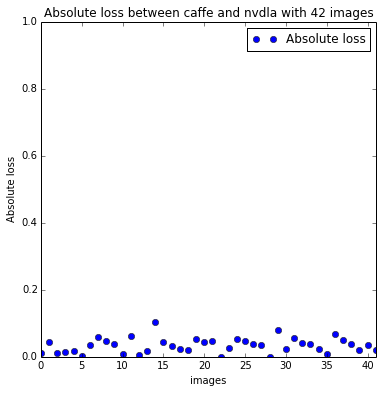

In [32]:
pixel_width = 6
pixel_height = 6
plt.figure(figsize=(pixel_width, pixel_height))
aa = range(0,42)
l1, = plt.plot(aa,caffe_nvdla_loss,'ro', label = 'Absolute loss', color = 'blue')

plt.xlim((0, 41))
plt.ylim((0, 1))
plt.title("Absolute loss between caffe and nvdla with 42 images")
plt.xlabel('images')
plt.ylabel('Absolute loss')

plt.legend() #, labels = ['caffe', 'no mean'], loc = 'best')

plt.show()
# print("-----------loss rate: %2.3f%% | cross entropy: %2.3f%% -----------------"%((caffe_nvdla_loss[z]*100),(caffe_nvdla_cross_entropy[z]*100)))
# 
# # print aa
# plt.plot(aa,predictions[0],'y--',aa, dimg_no_mean , 'r--', aa, dimg_mean_bgr, 'b--', aa, dimg_mean_rgb, 'g--')
# plt.axis([0, 50, 0, 1])
# plt.show()